In [1]:
import pandas as pd #importing the Pandas Library as 'pd'
import numpy as np

#Imports spatial libraries
from keplergl import KeplerGl #importing KeplerGl
import geopandas as gpd #importing geopandas as 'gpd'
from shapely.geometry import Point
from shapely.geometry import box
import shapely.wkt
from geopy.geocoders import Nominatim # Imports the geopy for the geocoding
import geojson
from geojson import Point, Feature, FeatureCollection, dump
from geojson_rewind import rewind
import json

# Import seaborn to visualise the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt


import xml.etree.ElementTree as ET
import requests



from time import time

In [2]:
ls Data/Out/

Affordable_food_iniatives.geojson  Liverpool_lsoa.geojson    education.geojson
Emergency_food_suppliers.geojson   Liverpool_wards.geojson   income.geojson
Food_outlets_geo.geojson           Obesity.geojson           morbidity.geojson
Isochrone.geojson                  Supermarkets_geo.geojson  population.geojson
Liverpool_boundary.geojson         crowding.geojson          score.geojson


# Read in the files

In [3]:
## Reads in the Liverpool boundary file
filename='Data/Out/Liverpool_lsoa.geojson'
Liverpool_lsoa = gpd.read_file(open(filename))

filename2='Data/Out/Affordable_food_iniatives.geojson'
Affordable_food_initatives = gpd.read_file(open(filename2))

filename3='Data/Out/Emergency_food_suppliers.geojson'
Emergency_food_suppliers = gpd.read_file(open(filename3))

filename4='Data/Out/Food_outlets_geo.geojson'
Food_outlets = gpd.read_file(open(filename4))

filename5='Data/Out/Supermarkets_geo.geojson'
Supermarkets = gpd.read_file(open(filename5))


In [4]:
Liverpool_lsoa.head(n=5)

,LSOA11CD,LSOA11NM,LSOA code (2011),LSOA name (2011)_x,Local Authority District code (2019)_x,Local Authority District name (2019)_x,Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),...,Housing in poor condition indicator_rank,Houses without central heating indicator_rank,Road traffic accidents indicator_rank,Nitrogen dioxide (component of air quality indicator)_rank,Benzene (component of air quality indicator)_rank,Sulphur dioxide (component of air quality indicator)_rank,Particulates (component of air quality indicator)_rank,Air quality indicator_rank,Score_rank,geometry
0,Liverpool 050G,Liverpool 050G,E01032506,Liverpool 050G,Liverpool 050G,E08000012,326,208,0,0,...,5,4,3,3,3,2,3,2,2,"POLYGON ((-2.95426 53.38099, -2.95408 53.38093..."
1,Liverpool 050H,Liverpool 050H,E01032507,Liverpool 050H,Liverpool 050H,E08000012,233,183,0,0,...,5,4,3,3,3,2,3,2,1,"POLYGON ((-2.95186 53.38009, -2.95182 53.38007..."
2,Liverpool 050F,Liverpool 050F,E01032505,Liverpool 050F,Liverpool 050F,E08000012,295,233,0,0,...,1,3,3,3,3,2,3,2,3,"POLYGON ((-2.96348 53.37651, -2.96314 53.37672..."
3,Liverpool 027G,Liverpool 027G,E01032508,Liverpool 027G,Liverpool 027G,E08000012,335,344,0,0,...,4,4,3,3,5,5,3,5,4,"POLYGON ((-2.91993 53.41418, -2.91991 53.41425..."
4,Liverpool 027H,Liverpool 027H,E01032509,Liverpool 027H,Liverpool 027H,E08000012,238,255,0,0,...,4,5,3,3,4,5,3,4,3,"POLYGON ((-2.92471 53.41143, -2.92470 53.41143..."


# Ensure that the projection of everything is consistent

In [5]:
Liverpool_lsoa['geometry'] = Liverpool_lsoa['geometry'].set_crs("EPSG:4326")

In [6]:
Affordable_food_iniatives = Affordable_food_initatives.set_crs("EPSG:4326")

In [7]:
Emergency_food_suppliers=Emergency_food_suppliers.set_crs("EPSG:4326")

Food_outlets=Food_outlets.set_crs("EPSG:4326")

Supermarkets=Supermarkets.set_crs("EPSG:4326")

# Do an assert to test that the projections are all the same

In [8]:
!pip install seaborn

In [9]:
Liverpool_lsoa["LSOA11CD"].value_counts()

Liverpool 057A    1
Liverpool 028D    1
Liverpool 003E    1
Liverpool 017E    1
Liverpool 016D    1
                 ..
Liverpool 001D    1
Liverpool 014B    1
Liverpool 040B    1
Liverpool 006B    1
Liverpool 053E    1
Name: LSOA11CD, Length: 298, dtype: int64

In [10]:
Liverpool_lsoa["LSOA name (2011)_x"].value_counts()

Liverpool 057A    1
Liverpool 028D    1
Liverpool 003E    1
Liverpool 017E    1
Liverpool 016D    1
                 ..
Liverpool 001D    1
Liverpool 014B    1
Liverpool 040B    1
Liverpool 006B    1
Liverpool 053E    1
Name: LSOA name (2011)_x, Length: 298, dtype: int64

In [11]:
# Split the initatives down into the different kinds of initatives

# Count the number of food banks, pantries etc by lower super output areas

In [12]:
list(Liverpool_lsoa)

['LSOA11CD',
 'LSOA11NM',
 'LSOA code (2011)',
 'LSOA name (2011)_x',
 'Local Authority District code (2019)_x',
 'Local Authority District name (2019)_x',
 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)',
 'LSOA name (2011)_y',
 'Local Authority District code (2019)_y',
 'Local Authority District name (2019)_y',
 'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 

In [13]:
# Class that is used to count the number of food outlets by lsoa

class Spatial_count:
    
  def __init__(self, spatial_polygon, spatial_points):
    
       self.spatial_polygon = spatial_polygon
       self.spatial_points=spatial_points
        
  #Counts the number of points falling within a given geography  
  def tablecount(self):

        # Does the spatial join
        dfsjoin = gpd.sjoin(self.spatial_polygon,self.spatial_points)
        
        # Creates a flag for the counts
        dfsjoin['flag']=1
 
        # Does a pivot table on the LSOA areas i.e. counts how many meetups by category (meetupcat) each geography has meetup groups for 
   
        dfpivot =dfsjoin[["LSOA11CD","flag"]].groupby(['LSOA11CD']).sum() #count().unstack(fill_value=0).stack()
    
      
  
        # Resets the index
        dfpivot=dfpivot.reset_index()
        

        return dfpivot
  

Note the categories that the emergany food initative split into ('Food_parcels','Meal_providers') and
Affordable food initatives ('Pantry','Community_cafes','Free_food_inititives') and 
Food outlets ('Pub/bar/nightclub','Takeaway/sandwich shop','Restaurant/Cafe/Canteen')


In [14]:
food_sites=[Affordable_food_iniatives,Emergency_food_suppliers, Supermarkets , Food_outlets ]

Liverpool_lsoa_extra=Liverpool_lsoa

for i, elem in enumerate(food_sites): 
       # Drop the Liverpool column this is a hack (remove later by using a different dataset to get the points within Liverpool)
       try:
        del elem['LSOA11CD']
       except:
         print("No such column")
       spatial_join=Spatial_count(Liverpool_lsoa_extra,elem)
       count_table=spatial_join.tablecount()
       # Rename the count 
       count_table=count_table.rename(columns={"flag":str(i)+"_count"})
      # Merge the counts with the Liverpool lower super output area data 
       print(count_table)
       Liverpool_lsoa_extra=Liverpool_lsoa_extra.merge(count_table, how='left',left_on=['LSOA11CD'],  right_on=['LSOA11CD'])
    
venue_counts=['0_count','1_count','2_count', '3_count'] 

Liverpool_lsoa_extra[venue_counts]=Liverpool_lsoa_extra[venue_counts].fillna(0)


No such column
          LSOA11CD  0_count
0   Liverpool 002A        1
1   Liverpool 002E        1
2   Liverpool 003D        1
3   Liverpool 004B        1
4   Liverpool 005E        1
5   Liverpool 007E        1
6   Liverpool 010F        2
7   Liverpool 013C        2
8   Liverpool 015A        1
9   Liverpool 016B        2
10  Liverpool 018F        2
11  Liverpool 019D        1
12  Liverpool 022D        1
13  Liverpool 022E        1
14  Liverpool 023C        1
15  Liverpool 024C        1
16  Liverpool 025A        1
17  Liverpool 025D        1
18  Liverpool 027G        1
19  Liverpool 028C        2
20  Liverpool 031C        1
21  Liverpool 037A        2
22  Liverpool 040C        1
23  Liverpool 043A        1
24  Liverpool 044C        1
25  Liverpool 045A        1
26  Liverpool 046B        1
27  Liverpool 052E        1
28  Liverpool 055B        1
29  Liverpool 059C        1
30  Liverpool 059D        2
31  Liverpool 061B        1
No such column
          LSOA11CD  1_count
0   Liverpool 001B

# Convert counts to density

In [15]:
Liverpool_lsoa_extra['area'] = Liverpool_lsoa_extra.geometry.area

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [16]:
for elem in venue_counts:
    Liverpool_lsoa_extra[elem+"_density"]= Liverpool_lsoa_extra[elem]/Liverpool_lsoa_extra['area']

In [17]:
# Change the labelling
Liverpool_lsoa_extra=Liverpool_lsoa_extra.rename(columns={'0_count_density':'Affordable_food_initatives_density','1_count_density': 'Emergency_food_suppliers_density' , '2_count_density':'Supermarkets_density', '3_count_density':'Foodoutlets_density'})


# Visualises the correlelogram

In [18]:
# Selects the variables that we want to be on the correelogram

correlogram_vars=['Affordable_food_initatives_density','Emergency_food_suppliers_density','Supermarkets_density', 'Foodoutlets_density', 'Income Domain numerator', 'Houses without central heating indicator','Total population: mid 2015 (excluding prisoners)']
                                               


In [19]:
correlogram_data=Liverpool_lsoa_extra[correlogram_vars]

Text(0.5, 1.0, 'Correlation between different activities')

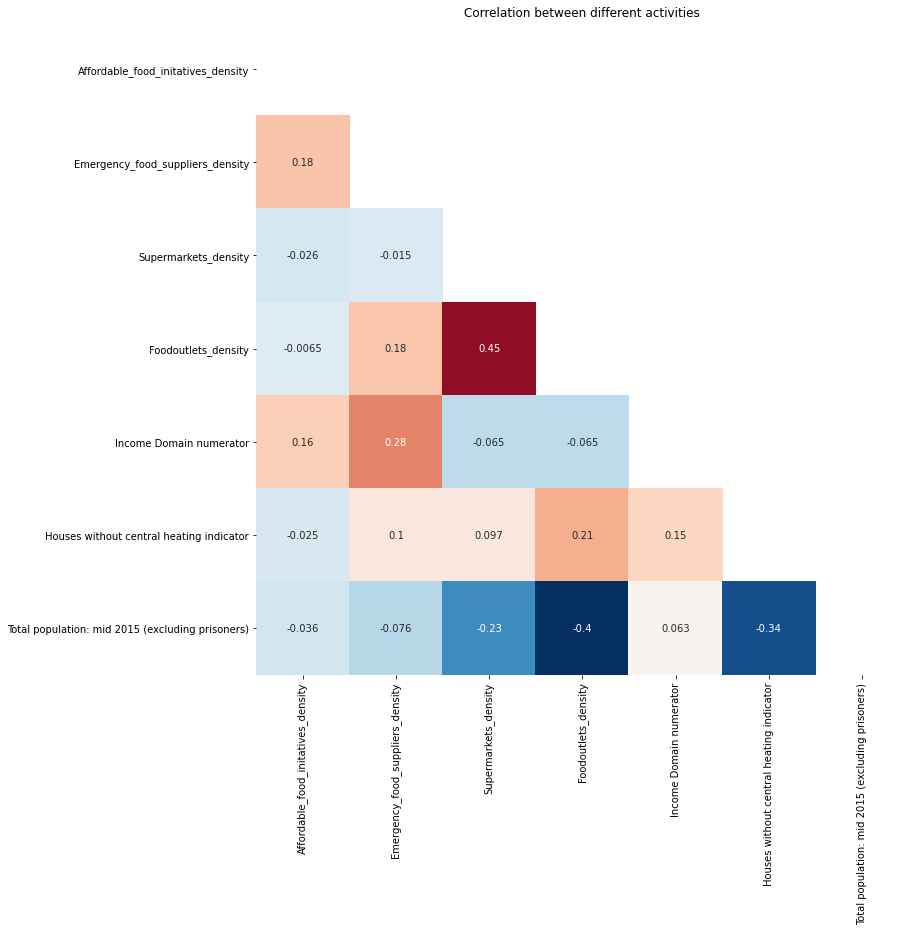

In [20]:
#Calculates coocurrence which is a symmetric matrix, with the diagonal being the % of respondents reporting the category
results=correlogram_data.corr()

#Creates a mask to hide the upper triangle excluding the diagonal by having k=0
matrix = np.triu(results, k=0)

#Plots the heatmap with seaborn
fig, ax = plt.subplots(figsize=(12,12))  
sns.heatmap(results, annot=True,ax=ax, mask=matrix,  cmap ='RdBu_r', vmax=0.5, square=True, cbar=False)
ax.set_title('Correlation between different activities')